In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import minimize
from lightgbm import LGBMModel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

pd.set_option('max_rows', 10)
pd.set_option('max_columns', None)
plt.style.use('bmh')

%matplotlib inline

In [5]:
data = pd.read_csv('data.csv', index_col='Id')
data.head()

,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,T1_V10,T1_V11,T1_V12,T1_V13,T1_V14,T1_V15,T1_V16,T1_V17,T2_V1,T2_V2,T2_V3,T2_V4,T2_V5,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,15,3,2,N,B,N,B,B,D,7,B,B,15,1,A,B,N,36,11,N,10,B,2,37,1,11,6,Y,N,E,2,2
2,4,16,14,5,H,B,N,B,B,C,12,B,B,10,3,A,B,Y,78,10,Y,17,C,2,22,1,18,5,Y,Y,E,2,1
3,1,10,10,5,N,K,N,B,B,E,12,H,B,15,1,A,R,Y,71,21,Y,13,C,6,37,2,14,6,Y,Y,E,6,1
4,1,18,18,5,N,K,N,B,B,E,3,H,B,15,1,A,R,N,71,13,N,15,A,2,25,1,1,6,Y,N,C,2,6
5,1,13,19,5,N,H,N,B,B,E,7,H,B,10,1,A,J,N,75,10,Y,11,B,1,22,1,2,7,N,N,E,1,1


In [6]:
categorical, numerical = list(), list()
for col in data.columns[1:]:
    if isinstance(data.loc[1, col], str):
        categorical.append(col)
    if isinstance(data.loc[1, col], np.int64):
        numerical.append(col)


In [7]:
data[categorical].nunique().values

array([ 8, 10,  2,  4,  4,  6, 12,  4,  8, 18,  2,  2,  6,  2,  2,  5],
      dtype=int64)

In [8]:
data[numerical].nunique().values

array([ 19,  24,   9,   5,   4,   5, 100,  39,  22,   7,   7,   3,  25,
         7,   7,  12], dtype=int64)

C:\anac\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


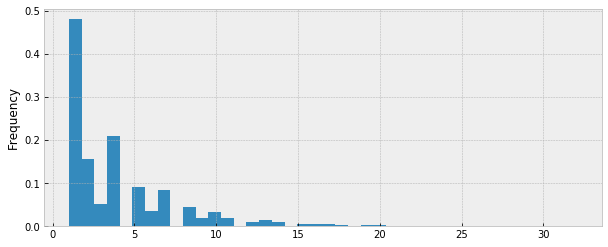

In [9]:
data['Hazard'].plot(kind='hist', figsize=(10, 4), bins=40, normed=True)
plt.show()

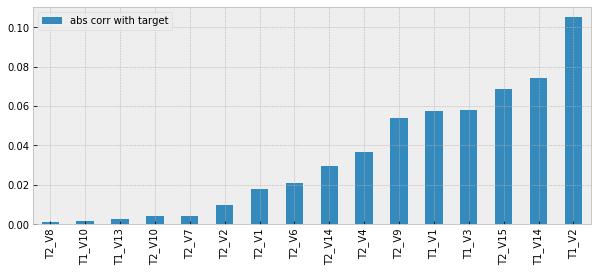

In [10]:
corrs = [data[col].corr(data['Hazard']) for col in numerical]
corrs = pd.DataFrame(np.abs(corrs), numerical, 
    ['abs corr with target']).sort_values('abs corr with target')
corrs.plot(kind='bar', figsize=(10, 4))
plt.show()

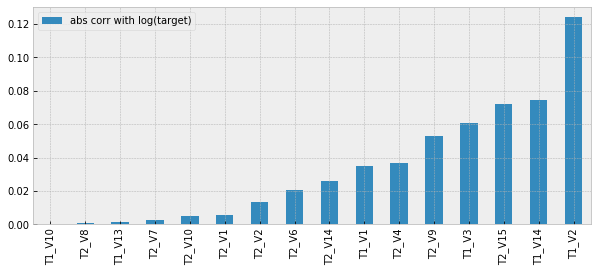

In [11]:
#log(targets)
log_corrs = [(data[col]).corr(np.log(data['Hazard'])) for col in numerical]
log_corrs = pd.DataFrame(np.abs(log_corrs), (numerical), 
    ['abs corr with log(target)']).sort_values('abs corr with log(target)')
log_corrs.plot(kind='bar', figsize=(10, 4))
plt.show()

In [12]:
for i in range(0,len(numerical)):
    if corrs['abs corr with target'][numerical[i]] < 0.005:
        data = data.drop(numerical[i], axis = 1)


In [13]:
label_encoder = LabelEncoder()
data[categorical] = data[categorical].apply(label_encoder.fit_transform)


In [14]:
objects = data.loc[:, 'T1_V1':]
labels = data['Hazard'] - 1

In [15]:
mask = objects.columns.isin(categorical)
onehot_encoder = OneHotEncoder(categorical_features=mask, sparse=False)
objects_encoded = onehot_encoder.fit_transform(objects)

C:\anac\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\anac\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [16]:
train_objects, test_objects, train_labels, test_labels = train_test_split(
    objects_encoded, labels.as_matrix(), random_state=1, test_size=0.2, stratify=labels
)



C:\anac\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [423]:
def oracle(w, X, y):

    loss = np.sum(np.exp(np.dot(X,w)) - y*np.dot(X,w))      
    grad = np.dot(X.T, (np.exp(np.dot(X,w)) - y))

    return loss, grad

In [424]:
train_objects_bias = train_objects #+ np.ones((train_objects.shape[0],1), dtype=np.int64)
test_objects_bias = test_objects #+ np.ones((test_objects.shape[0],1), dtype=np.int64)
train_objects_bias = np.append(train_objects_bias, np.ones((train_objects.shape[0],1), dtype=np.int64), axis=1)
test_objects_bias = np.append(test_objects_bias, np.ones((test_objects.shape[0],1), dtype=np.int64), axis=1)

In [425]:
def gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [428]:
w=np.random.randn(train_objects_bias.shape[1])
poisson_results = minimize(oracle, x0 = w, args=(train_objects_bias, train_labels), method='L-BFGS-B', jac=True) #change parameters
pred_labels = np.exp(np.dot(test_objects_bias, poisson_results.x)) # w = poisson_results.x
gini(test_labels, pred_labels)

0.3180768284476543

In [190]:
linear = LinearRegression().fit(train_objects, train_labels)
linear.score(train_objects, train_labels)
lin_predict_labels = linear.predict(test_objects)
gini(test_labels, lin_predict_labels)

0.31547097574551297

In [64]:
import statsmodels.api as sm

In [65]:
gaussian_sm_model = sm.GLM(train_labels, train_objects, family=sm.families.Gaussian())
gaussian_sm_results = gaussian_sm_model.fit()
pred_labels = gaussian_sm_results.predict(test_objects)
gini(test_labels, pred_labels)

0.3155018119431411

In [40]:
poisson_sm_model = sm.GLM(train_labels, train_objects, family=sm.families.Poisson())
poisson_sm_results = poisson_sm_model.fit()
pos_pred_labels = poisson_sm_results.predict(test_objects)
gini(test_labels, pos_pred_labels)

0.31805980727499006

In [41]:
negative_binomial_sm_model = sm.GLM(train_labels, train_objects, family=sm.families.NegativeBinomial())
negative_binomial_sm_results = negative_binomial_sm_model.fit()
negative_bin_pred_labels = negative_binomial_sm_results.predict(test_objects)
gini(test_labels, negative_bin_pred_labels)

0.3188816429950859

In [42]:
import lightgbm as lgb

In [420]:
reg_gbm = lgb.LGBMModel( 
                        learning_rate = 0.1,
                        max_depth = 8,
                        n_estimators = 100,
                        num_leaves = 16,
                        objective = "regression")

In [421]:
reg_gbm.fit(train_objects, train_labels)
predict_labels = reg_gbm.predict(test_objects)
print(gini(test_labels,predict_labels))

0.35904881276146433


In [51]:
pos_gbm = lgb.LGBMModel( 
                        learning_rate = 0.1,
                        max_depth = 8,
                        n_estimators = 100,
                        num_leaves = 16,
                        objective = "poisson")

In [422]:
pos_gbm.fit(train_objects, train_labels)
predict_labels = pos_gbm.predict(test_objects)
print(gini(test_labels,predict_labels))

0.3614048718414951
